# Computer Vision Homework 3: Big vs Small Models

## Brief

Due date: Nov 13, 2023

Required files: `homework-3.ipynb`, `report.pdf`

To download the jupyter notebook from colab, you can refer to the colab tutorial we gave.


## Codes for Problem 1 and Problem 2

### Import Packages

In [ ]:
import glob
import os
import random

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.optim as optim

from PIL import Image
from torch.utils.data import DataLoader, Dataset, RandomSampler
from torchvision import transforms, models, datasets
from tqdm import tqdm

%matplotlib inline

In [ ]:
from torch.utils.tensorboard import SummaryWriter
os.system('rm -r runs')
print('removing previos run dir')
writer = SummaryWriter()

removing previos run dir


### Check GPU Environment

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using {device} device')

Using cuda device


In [ ]:
! nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-9dd7ed16-b1b7-7c50-fa56-0d74df09da6f)


### Set the Seed to Reproduce the Result

In [ ]:
def set_all_seed(seed):
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
set_all_seed(123)

### Create Dataset and Dataloader

In [ ]:
batch_size = 256

mean = (0.4914, 0.4822, 0.4465)
std = (0.2471, 0.2435, 0.2616)
train_transform = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
])
test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
])

train_dataset = datasets.CIFAR10(root='data', train=True, download=True, transform=train_transform)
valid_dataset = datasets.CIFAR10(root='data', train=False, download=True, transform=test_transform)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, pin_memory=True)

sixteenth_train_sampler = RandomSampler(train_dataset, num_samples=len(train_dataset)//16)
half_train_sampler = RandomSampler(train_dataset, num_samples=len(train_dataset)//2)

sixteenth_train_dataloader = DataLoader(train_dataset, batch_size=batch_size, sampler=sixteenth_train_sampler)
half_train_dataloader = DataLoader(train_dataset, batch_size=batch_size, sampler=half_train_sampler)

100%|██████████| 170498071/170498071 [00:12<00:00, 13512664.96it/s]


Extracting data/cifar-10-python.tar.gz to data
Files already downloaded and verified


### Load Models

In [ ]:
# HINT: Remember to change the model to 'resnet50' and the weights to weights="IMAGENET1K_V1" when needed.
model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet50', weights=None)

# Background: The original resnet18 is designed for ImageNet dataset to predict 1000 classes.
# TODO: Change the output of the model to 10 class.
model.fc = nn.Linear(model.fc.in_features, out_features=10, bias=True)
model = model.to(device)

Downloading: "https://github.com/pytorch/vision/zipball/v0.10.0" to /root/.cache/torch/hub/v0.10.0.zip


### Training and Testing Models

In [ ]:
# TODO: Fill in the code cell according to the pytorch tutorial we gave.
def train(dataloader, model, loss_fn, optimizer):
    num_batches = len(dataloader)
    size = len(dataloader.dataset)
    epoch_loss = 0
    correct = 0

    model.train()

    for X, y in tqdm(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        pred = pred.argmax(dim=1, keepdim=True)
        correct += pred.eq(y.view_as(pred)).sum().item()

    avg_epoch_loss = epoch_loss / num_batches
    avg_acc = correct / size

    return avg_epoch_loss, avg_acc

def test(dataloader, model, loss_fn):
    num_batches = len(dataloader)
    size = len(dataloader.dataset)
    epoch_loss = 0
    correct = 0

    model.eval()

    with torch.no_grad():
        for X, y in tqdm(dataloader):
            X, y = X.to(device), y.to(device)

            pred = model(X)

            epoch_loss += loss_fn(pred, y).item()
            pred = pred.argmax(dim=1, keepdim=True)
            correct += pred.eq(y.view_as(pred)).sum().item()

    avg_epoch_loss = epoch_loss / num_batches
    avg_acc = correct / size

    return avg_epoch_loss, avg_acc

In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)

epochs = 200

In [ ]:
train_loss_list = []
train_acc_list = []
test_loss_list = []
test_acc_list = []
best_acc = 0

for epoch in range(epochs):
    train_loss, train_acc = train(train_dataloader, model, loss_fn, optimizer)
    test_loss, test_acc = test(valid_dataloader, model, loss_fn)
    train_loss_list.append(train_loss)
    train_acc_list.append(train_acc)
    test_loss_list.append(test_loss)
    test_acc_list.append(test_acc)
    if test_acc > best_acc:
      best_acc = test_acc
    print(f"Epoch {epoch + 1:2d}: Loss = {train_loss:.4f} Acc = {train_acc:.2f} Test_Loss = {test_loss:.4f} Test_Acc = {test_acc:.2f}")
    writer.add_scalar('Loss/train', train_loss, epoch)
    writer.add_scalar('Loss/test', test_loss, epoch)
    writer.add_scalar('Acc/train', train_acc, epoch)
    writer.add_scalar('Acc/test', test_acc, epoch)

writer.close()

100%|██████████| 40/40 [00:04<00:00,  8.45it/s]


Epoch  1: Loss = 1.9276 Acc = 0.32 Test_Loss = 3.0001 Test_Acc = 0.40


100%|██████████| 40/40 [00:03<00:00, 11.43it/s]


Epoch  2: Loss = 1.5719 Acc = 0.43 Test_Loss = 1.4770 Test_Acc = 0.45


100%|██████████| 40/40 [00:03<00:00, 11.53it/s]


Epoch  3: Loss = 1.5018 Acc = 0.47 Test_Loss = 2.4013 Test_Acc = 0.47


100%|██████████| 40/40 [00:04<00:00,  8.99it/s]


Epoch  4: Loss = 1.4500 Acc = 0.49 Test_Loss = 2.8797 Test_Acc = 0.49


100%|██████████| 40/40 [00:03<00:00, 11.28it/s]


Epoch  5: Loss = 1.4407 Acc = 0.50 Test_Loss = 3.0673 Test_Acc = 0.42


100%|██████████| 40/40 [00:03<00:00, 11.57it/s]


Epoch  6: Loss = 1.4688 Acc = 0.49 Test_Loss = 1.3285 Test_Acc = 0.55


100%|██████████| 40/40 [00:04<00:00,  9.56it/s]


Epoch  7: Loss = 1.3017 Acc = 0.55 Test_Loss = 2.3540 Test_Acc = 0.58


100%|██████████| 40/40 [00:03<00:00, 10.68it/s]


Epoch  8: Loss = 1.5182 Acc = 0.48 Test_Loss = 129.9898 Test_Acc = 0.24


100%|██████████| 40/40 [00:03<00:00, 11.57it/s]


Epoch  9: Loss = 1.4145 Acc = 0.50 Test_Loss = 1.1826 Test_Acc = 0.58


100%|██████████| 40/40 [00:03<00:00, 11.13it/s]


Epoch 10: Loss = 1.1982 Acc = 0.58 Test_Loss = 5.7877 Test_Acc = 0.56


100%|██████████| 40/40 [00:04<00:00,  9.21it/s]


Epoch 11: Loss = 1.1552 Acc = 0.59 Test_Loss = 1.2131 Test_Acc = 0.60


100%|██████████| 40/40 [00:03<00:00, 11.65it/s]


Epoch 12: Loss = 1.0785 Acc = 0.63 Test_Loss = 0.9717 Test_Acc = 0.66


100%|██████████| 40/40 [00:03<00:00, 11.54it/s]


Epoch 13: Loss = 1.5034 Acc = 0.48 Test_Loss = 6.3742 Test_Acc = 0.26


100%|██████████| 40/40 [00:03<00:00, 10.23it/s]


Epoch 14: Loss = 1.8428 Acc = 0.34 Test_Loss = 1.6628 Test_Acc = 0.38


100%|██████████| 40/40 [00:04<00:00,  9.59it/s]


Epoch 15: Loss = 1.7110 Acc = 0.39 Test_Loss = 1.8870 Test_Acc = 0.30


100%|██████████| 40/40 [00:03<00:00, 11.72it/s]


Epoch 16: Loss = 1.6464 Acc = 0.40 Test_Loss = 1.5694 Test_Acc = 0.48


100%|██████████| 40/40 [00:03<00:00, 11.48it/s]


Epoch 17: Loss = 1.4590 Acc = 0.48 Test_Loss = 1.6471 Test_Acc = 0.44


100%|██████████| 40/40 [00:04<00:00,  8.79it/s]


Epoch 18: Loss = 1.6644 Acc = 0.41 Test_Loss = 1.6267 Test_Acc = 0.42


100%|██████████| 40/40 [00:03<00:00, 11.65it/s]


Epoch 19: Loss = 1.4914 Acc = 0.47 Test_Loss = 1.5730 Test_Acc = 0.47


100%|██████████| 40/40 [00:03<00:00, 11.53it/s]


Epoch 20: Loss = 1.4096 Acc = 0.50 Test_Loss = 1.4605 Test_Acc = 0.52


100%|██████████| 40/40 [00:04<00:00,  9.48it/s]


Epoch 21: Loss = 1.3747 Acc = 0.51 Test_Loss = 1.5454 Test_Acc = 0.52


100%|██████████| 40/40 [00:03<00:00, 10.65it/s]


Epoch 22: Loss = 1.3406 Acc = 0.53 Test_Loss = 4.1165 Test_Acc = 0.54


100%|██████████| 40/40 [00:03<00:00, 11.80it/s]


Epoch 23: Loss = 1.2271 Acc = 0.57 Test_Loss = 1.1229 Test_Acc = 0.59


100%|██████████| 40/40 [00:03<00:00, 11.40it/s]


Epoch 24: Loss = 1.1211 Acc = 0.60 Test_Loss = 1.0809 Test_Acc = 0.61


100%|██████████| 40/40 [00:04<00:00,  8.61it/s]


Epoch 25: Loss = 1.0555 Acc = 0.62 Test_Loss = 1.0621 Test_Acc = 0.64


100%|██████████| 40/40 [00:03<00:00, 11.48it/s]


Epoch 26: Loss = 1.0121 Acc = 0.64 Test_Loss = 1.1483 Test_Acc = 0.60


100%|██████████| 40/40 [00:03<00:00, 11.71it/s]


Epoch 27: Loss = 1.5228 Acc = 0.46 Test_Loss = 3.5013 Test_Acc = 0.50


100%|██████████| 40/40 [00:04<00:00,  9.04it/s]


Epoch 28: Loss = 1.3894 Acc = 0.51 Test_Loss = 1.1363 Test_Acc = 0.59


100%|██████████| 40/40 [00:03<00:00, 11.35it/s]


Epoch 29: Loss = 1.2272 Acc = 0.57 Test_Loss = 1.0418 Test_Acc = 0.63


100%|██████████| 40/40 [00:03<00:00, 11.70it/s]


Epoch 30: Loss = 1.1275 Acc = 0.61 Test_Loss = 1.2049 Test_Acc = 0.64


100%|██████████| 40/40 [00:03<00:00, 10.93it/s]


Epoch 31: Loss = 1.0541 Acc = 0.63 Test_Loss = 1.0262 Test_Acc = 0.66


100%|██████████| 40/40 [00:04<00:00,  9.20it/s]


Epoch 32: Loss = 1.0386 Acc = 0.63 Test_Loss = 1.0862 Test_Acc = 0.67


100%|██████████| 40/40 [00:03<00:00, 11.58it/s]


Epoch 33: Loss = 0.9283 Acc = 0.67 Test_Loss = 0.8693 Test_Acc = 0.70


100%|██████████| 40/40 [00:03<00:00, 11.78it/s]


Epoch 34: Loss = 0.8720 Acc = 0.69 Test_Loss = 0.8112 Test_Acc = 0.72


100%|██████████| 40/40 [00:04<00:00,  8.66it/s]


Epoch 35: Loss = 0.8321 Acc = 0.70 Test_Loss = 0.8338 Test_Acc = 0.70


100%|██████████| 40/40 [00:03<00:00, 11.78it/s]


Epoch 36: Loss = 0.8638 Acc = 0.69 Test_Loss = 0.8676 Test_Acc = 0.70


100%|██████████| 40/40 [00:03<00:00, 11.83it/s]


Epoch 37: Loss = 0.8472 Acc = 0.70 Test_Loss = 0.8365 Test_Acc = 0.71


100%|██████████| 40/40 [00:03<00:00, 10.99it/s]


Epoch 38: Loss = 0.7602 Acc = 0.73 Test_Loss = 0.7634 Test_Acc = 0.73


100%|██████████| 40/40 [00:04<00:00,  9.34it/s]


Epoch 39: Loss = 0.7402 Acc = 0.74 Test_Loss = 0.7591 Test_Acc = 0.73


100%|██████████| 40/40 [00:03<00:00, 11.85it/s]


Epoch 40: Loss = 0.7078 Acc = 0.75 Test_Loss = 0.7403 Test_Acc = 0.74


100%|██████████| 40/40 [00:03<00:00, 11.64it/s]


Epoch 41: Loss = 0.6881 Acc = 0.76 Test_Loss = 0.7203 Test_Acc = 0.76


100%|██████████| 40/40 [00:04<00:00,  8.67it/s]


Epoch 42: Loss = 0.6581 Acc = 0.77 Test_Loss = 0.6933 Test_Acc = 0.76


100%|██████████| 40/40 [00:03<00:00, 12.09it/s]


Epoch 43: Loss = 0.6403 Acc = 0.77 Test_Loss = 0.6953 Test_Acc = 0.76


100%|██████████| 40/40 [00:03<00:00, 11.81it/s]


Epoch 44: Loss = 0.6229 Acc = 0.78 Test_Loss = 0.6604 Test_Acc = 0.77


100%|██████████| 40/40 [00:04<00:00,  9.86it/s]


Epoch 45: Loss = 0.5991 Acc = 0.79 Test_Loss = 0.7061 Test_Acc = 0.76


100%|██████████| 40/40 [00:03<00:00, 10.72it/s]


Epoch 46: Loss = 0.5801 Acc = 0.79 Test_Loss = 0.6466 Test_Acc = 0.78


100%|██████████| 40/40 [00:03<00:00, 11.79it/s]


Epoch 47: Loss = 0.5664 Acc = 0.80 Test_Loss = 0.6531 Test_Acc = 0.78


100%|██████████| 40/40 [00:03<00:00, 11.87it/s]


Epoch 48: Loss = 0.5537 Acc = 0.80 Test_Loss = 0.6411 Test_Acc = 0.78


100%|██████████| 40/40 [00:04<00:00,  8.71it/s]


Epoch 49: Loss = 0.5330 Acc = 0.81 Test_Loss = 0.6088 Test_Acc = 0.79


100%|██████████| 40/40 [00:03<00:00, 11.00it/s]


Epoch 50: Loss = 0.5132 Acc = 0.82 Test_Loss = 0.6212 Test_Acc = 0.79


100%|██████████| 40/40 [00:03<00:00, 11.29it/s]


Epoch 51: Loss = 0.5007 Acc = 0.82 Test_Loss = 0.6166 Test_Acc = 0.79


100%|██████████| 40/40 [00:04<00:00,  9.20it/s]


Epoch 52: Loss = 0.4835 Acc = 0.83 Test_Loss = 0.6563 Test_Acc = 0.78


100%|██████████| 40/40 [00:03<00:00, 10.63it/s]


Epoch 53: Loss = 1.1063 Acc = 0.64 Test_Loss = 1.0476 Test_Acc = 0.68


100%|██████████| 40/40 [00:03<00:00, 11.20it/s]


Epoch 54: Loss = 0.8595 Acc = 0.72 Test_Loss = 0.7839 Test_Acc = 0.75


100%|██████████| 40/40 [00:04<00:00,  9.92it/s]


Epoch 55: Loss = 0.8550 Acc = 0.70 Test_Loss = 0.9377 Test_Acc = 0.76


100%|██████████| 40/40 [00:04<00:00,  8.67it/s]


Epoch 56: Loss = 0.6455 Acc = 0.77 Test_Loss = 0.7727 Test_Acc = 0.77


100%|██████████| 40/40 [00:03<00:00, 11.43it/s]


Epoch 57: Loss = 0.5736 Acc = 0.80 Test_Loss = 0.6921 Test_Acc = 0.77


100%|██████████| 40/40 [00:03<00:00, 11.75it/s]


Epoch 58: Loss = 0.5159 Acc = 0.82 Test_Loss = 0.6173 Test_Acc = 0.79


100%|██████████| 40/40 [00:04<00:00,  8.64it/s]


Epoch 59: Loss = 0.4851 Acc = 0.83 Test_Loss = 0.6307 Test_Acc = 0.80


100%|██████████| 40/40 [00:03<00:00, 11.59it/s]


Epoch 60: Loss = 0.4575 Acc = 0.84 Test_Loss = 0.5900 Test_Acc = 0.80


100%|██████████| 40/40 [00:03<00:00, 11.61it/s]


Epoch 61: Loss = 0.4375 Acc = 0.84 Test_Loss = 0.6083 Test_Acc = 0.80


100%|██████████| 40/40 [00:04<00:00,  8.43it/s]


Epoch 62: Loss = 0.4141 Acc = 0.85 Test_Loss = 0.6118 Test_Acc = 0.80


100%|██████████| 40/40 [00:03<00:00, 11.32it/s]


Epoch 63: Loss = 0.3963 Acc = 0.86 Test_Loss = 0.6119 Test_Acc = 0.81


100%|██████████| 40/40 [00:03<00:00, 11.27it/s]


Epoch 64: Loss = 0.3856 Acc = 0.86 Test_Loss = 0.6030 Test_Acc = 0.81


100%|██████████| 40/40 [00:04<00:00,  8.47it/s]


Epoch 65: Loss = 0.3775 Acc = 0.87 Test_Loss = 0.5908 Test_Acc = 0.81


100%|██████████| 40/40 [00:03<00:00, 11.59it/s]


Epoch 66: Loss = 0.3754 Acc = 0.87 Test_Loss = 0.6043 Test_Acc = 0.81


100%|██████████| 40/40 [00:03<00:00, 11.57it/s]


Epoch 67: Loss = 0.5311 Acc = 0.82 Test_Loss = 0.5979 Test_Acc = 0.80


100%|██████████| 40/40 [00:04<00:00,  8.35it/s]


Epoch 68: Loss = 0.3759 Acc = 0.87 Test_Loss = 0.6063 Test_Acc = 0.81


100%|██████████| 40/40 [00:03<00:00, 11.45it/s]


Epoch 69: Loss = 0.3421 Acc = 0.88 Test_Loss = 0.6131 Test_Acc = 0.81


100%|██████████| 40/40 [00:03<00:00, 11.40it/s]


Epoch 70: Loss = 0.3314 Acc = 0.88 Test_Loss = 0.6707 Test_Acc = 0.79


100%|██████████| 40/40 [00:04<00:00,  8.70it/s]


Epoch 71: Loss = 0.4320 Acc = 0.85 Test_Loss = 0.6150 Test_Acc = 0.81


100%|██████████| 40/40 [00:03<00:00, 11.44it/s]


Epoch 72: Loss = 0.3185 Acc = 0.89 Test_Loss = 0.6170 Test_Acc = 0.81


100%|██████████| 40/40 [00:03<00:00, 11.64it/s]


Epoch 73: Loss = 0.3005 Acc = 0.89 Test_Loss = 0.6214 Test_Acc = 0.81


100%|██████████| 40/40 [00:03<00:00, 10.94it/s]


Epoch 74: Loss = 0.2834 Acc = 0.90 Test_Loss = 0.6185 Test_Acc = 0.82


100%|██████████| 40/40 [00:04<00:00,  9.37it/s]


Epoch 75: Loss = 0.2753 Acc = 0.90 Test_Loss = 0.6124 Test_Acc = 0.82


100%|██████████| 40/40 [00:03<00:00, 11.08it/s]


Epoch 76: Loss = 0.2624 Acc = 0.90 Test_Loss = 0.6299 Test_Acc = 0.82


100%|██████████| 40/40 [00:03<00:00, 11.42it/s]


Epoch 77: Loss = 0.2576 Acc = 0.91 Test_Loss = 0.6281 Test_Acc = 0.81


100%|██████████| 40/40 [00:04<00:00,  8.97it/s]


Epoch 78: Loss = 0.2432 Acc = 0.91 Test_Loss = 0.6449 Test_Acc = 0.81


100%|██████████| 40/40 [00:03<00:00, 11.69it/s]


Epoch 79: Loss = 0.2324 Acc = 0.92 Test_Loss = 0.6495 Test_Acc = 0.82


100%|██████████| 40/40 [00:04<00:00,  8.37it/s]


Epoch 80: Loss = 0.2312 Acc = 0.92 Test_Loss = 0.6442 Test_Acc = 0.81


100%|██████████| 40/40 [00:04<00:00,  8.75it/s]


Epoch 81: Loss = 0.2229 Acc = 0.92 Test_Loss = 0.7022 Test_Acc = 0.81


100%|██████████| 40/40 [00:03<00:00, 11.76it/s]


Epoch 82: Loss = 0.2301 Acc = 0.92 Test_Loss = 0.6365 Test_Acc = 0.82


100%|██████████| 40/40 [00:03<00:00, 11.70it/s]


Epoch 83: Loss = 0.2139 Acc = 0.92 Test_Loss = 0.6527 Test_Acc = 0.82


100%|██████████| 40/40 [00:04<00:00,  8.40it/s]


Epoch 84: Loss = 0.2029 Acc = 0.93 Test_Loss = 0.6752 Test_Acc = 0.82


100%|██████████| 40/40 [00:03<00:00, 11.21it/s]


Epoch 85: Loss = 0.1917 Acc = 0.93 Test_Loss = 0.6760 Test_Acc = 0.81


100%|██████████| 40/40 [00:03<00:00, 11.35it/s]


Epoch 86: Loss = 0.1831 Acc = 0.93 Test_Loss = 0.7001 Test_Acc = 0.82


100%|██████████| 40/40 [00:04<00:00,  9.03it/s]


Epoch 87: Loss = 0.2118 Acc = 0.93 Test_Loss = 0.6984 Test_Acc = 0.82


100%|██████████| 40/40 [00:04<00:00,  9.76it/s]


Epoch 88: Loss = 0.1855 Acc = 0.93 Test_Loss = 0.7405 Test_Acc = 0.81


100%|██████████| 40/40 [00:03<00:00, 11.35it/s]


Epoch 89: Loss = 0.1757 Acc = 0.94 Test_Loss = 0.7118 Test_Acc = 0.82


100%|██████████| 40/40 [00:03<00:00, 11.44it/s]


Epoch 90: Loss = 0.1825 Acc = 0.94 Test_Loss = 0.6961 Test_Acc = 0.82


100%|██████████| 40/40 [00:04<00:00,  8.48it/s]


Epoch 91: Loss = 0.2361 Acc = 0.92 Test_Loss = 0.7089 Test_Acc = 0.81


100%|██████████| 40/40 [00:03<00:00, 11.46it/s]


Epoch 92: Loss = 0.1656 Acc = 0.94 Test_Loss = 0.7147 Test_Acc = 0.82


100%|██████████| 40/40 [00:03<00:00, 11.87it/s]


Epoch 93: Loss = 0.1719 Acc = 0.94 Test_Loss = 0.6939 Test_Acc = 0.82


100%|██████████| 40/40 [00:04<00:00,  8.95it/s]


Epoch 94: Loss = 0.1481 Acc = 0.95 Test_Loss = 0.7543 Test_Acc = 0.81


100%|██████████| 40/40 [00:03<00:00, 11.11it/s]


Epoch 95: Loss = 0.1545 Acc = 0.94 Test_Loss = 0.6994 Test_Acc = 0.83


100%|██████████| 40/40 [00:03<00:00, 11.70it/s]


Epoch 96: Loss = 0.1353 Acc = 0.95 Test_Loss = 0.7394 Test_Acc = 0.82


100%|██████████| 40/40 [00:05<00:00,  7.90it/s]


Epoch 97: Loss = 0.1234 Acc = 0.96 Test_Loss = 0.7531 Test_Acc = 0.83


100%|██████████| 40/40 [00:03<00:00, 11.42it/s]


Epoch 98: Loss = 0.1219 Acc = 0.96 Test_Loss = 0.7438 Test_Acc = 0.82


100%|██████████| 40/40 [00:03<00:00, 10.56it/s]


Epoch 99: Loss = 0.1201 Acc = 0.96 Test_Loss = 0.7597 Test_Acc = 0.82


100%|██████████| 40/40 [00:04<00:00,  8.22it/s]


Epoch 100: Loss = 0.1190 Acc = 0.96 Test_Loss = 0.7219 Test_Acc = 0.82


100%|██████████| 40/40 [00:03<00:00, 11.20it/s]


Epoch 101: Loss = 0.1179 Acc = 0.96 Test_Loss = 0.7787 Test_Acc = 0.82


100%|██████████| 40/40 [00:03<00:00, 10.17it/s]


Epoch 102: Loss = 0.1162 Acc = 0.96 Test_Loss = 0.7484 Test_Acc = 0.83


100%|██████████| 40/40 [00:04<00:00,  9.15it/s]


Epoch 103: Loss = 0.1120 Acc = 0.96 Test_Loss = 0.8522 Test_Acc = 0.81


100%|██████████| 40/40 [00:03<00:00, 11.39it/s]


Epoch 104: Loss = 0.1102 Acc = 0.96 Test_Loss = 0.7637 Test_Acc = 0.82


100%|██████████| 40/40 [00:04<00:00,  9.02it/s]


Epoch 105: Loss = 0.1061 Acc = 0.96 Test_Loss = 0.7556 Test_Acc = 0.82


100%|██████████| 40/40 [00:03<00:00, 10.54it/s]


Epoch 106: Loss = 0.1038 Acc = 0.96 Test_Loss = 0.7994 Test_Acc = 0.82


100%|██████████| 40/40 [00:03<00:00, 10.77it/s]


Epoch 107: Loss = 0.1076 Acc = 0.96 Test_Loss = 0.7627 Test_Acc = 0.82


100%|██████████| 40/40 [00:04<00:00,  9.01it/s]


Epoch 108: Loss = 0.1020 Acc = 0.96 Test_Loss = 0.7931 Test_Acc = 0.82


100%|██████████| 40/40 [00:03<00:00, 11.37it/s]


Epoch 109: Loss = 0.1031 Acc = 0.96 Test_Loss = 0.7741 Test_Acc = 0.82


100%|██████████| 40/40 [00:03<00:00, 11.63it/s]


Epoch 110: Loss = 0.0933 Acc = 0.97 Test_Loss = 0.7939 Test_Acc = 0.82


100%|██████████| 40/40 [00:04<00:00,  9.95it/s]


Epoch 111: Loss = 0.1005 Acc = 0.96 Test_Loss = 0.8047 Test_Acc = 0.82


100%|██████████| 40/40 [00:04<00:00,  9.97it/s]


Epoch 112: Loss = 0.0921 Acc = 0.97 Test_Loss = 0.7804 Test_Acc = 0.82


100%|██████████| 40/40 [00:03<00:00, 11.79it/s]


Epoch 113: Loss = 0.0894 Acc = 0.97 Test_Loss = 0.7812 Test_Acc = 0.82


100%|██████████| 40/40 [00:03<00:00, 11.74it/s]


Epoch 114: Loss = 0.0845 Acc = 0.97 Test_Loss = 0.8186 Test_Acc = 0.82


100%|██████████| 40/40 [00:04<00:00,  8.43it/s]


Epoch 115: Loss = 0.0951 Acc = 0.97 Test_Loss = 0.8062 Test_Acc = 0.83


100%|██████████| 40/40 [00:03<00:00, 12.04it/s]


Epoch 116: Loss = 0.0908 Acc = 0.97 Test_Loss = 0.7907 Test_Acc = 0.83


100%|██████████| 40/40 [00:03<00:00, 11.73it/s]


Epoch 117: Loss = 0.0823 Acc = 0.97 Test_Loss = 0.8361 Test_Acc = 0.82


100%|██████████| 40/40 [00:04<00:00,  9.33it/s]


Epoch 118: Loss = 0.0828 Acc = 0.97 Test_Loss = 0.7884 Test_Acc = 0.83


100%|██████████| 40/40 [00:03<00:00, 10.95it/s]


Epoch 119: Loss = 0.0798 Acc = 0.97 Test_Loss = 0.8341 Test_Acc = 0.82


100%|██████████| 40/40 [00:03<00:00, 11.32it/s]


Epoch 120: Loss = 0.0809 Acc = 0.97 Test_Loss = 0.8189 Test_Acc = 0.83


100%|██████████| 40/40 [00:03<00:00, 10.83it/s]


Epoch 121: Loss = 0.0770 Acc = 0.97 Test_Loss = 0.7969 Test_Acc = 0.83


100%|██████████| 40/40 [00:04<00:00,  9.34it/s]


Epoch 122: Loss = 0.0767 Acc = 0.97 Test_Loss = 0.8205 Test_Acc = 0.82


100%|██████████| 40/40 [00:03<00:00, 11.69it/s]


Epoch 123: Loss = 0.0725 Acc = 0.97 Test_Loss = 0.8252 Test_Acc = 0.82


100%|██████████| 40/40 [00:03<00:00, 11.59it/s]


Epoch 124: Loss = 0.0829 Acc = 0.97 Test_Loss = 0.8662 Test_Acc = 0.82


100%|██████████| 40/40 [00:04<00:00,  8.74it/s]


Epoch 125: Loss = 0.0758 Acc = 0.97 Test_Loss = 0.8328 Test_Acc = 0.83


100%|██████████| 40/40 [00:03<00:00, 11.65it/s]


Epoch 126: Loss = 0.0741 Acc = 0.98 Test_Loss = 0.8224 Test_Acc = 0.83


100%|██████████| 40/40 [00:03<00:00, 11.55it/s]


Epoch 127: Loss = 0.0702 Acc = 0.98 Test_Loss = 0.8379 Test_Acc = 0.83


100%|██████████| 40/40 [00:03<00:00, 10.42it/s]


Epoch 128: Loss = 0.0660 Acc = 0.98 Test_Loss = 0.8356 Test_Acc = 0.83


100%|██████████| 40/40 [00:04<00:00,  9.51it/s]


Epoch 129: Loss = 0.0676 Acc = 0.98 Test_Loss = 0.8415 Test_Acc = 0.83


100%|██████████| 40/40 [00:03<00:00, 11.40it/s]


Epoch 130: Loss = 0.0677 Acc = 0.98 Test_Loss = 0.8184 Test_Acc = 0.83


100%|██████████| 40/40 [00:03<00:00, 10.83it/s]


Epoch 131: Loss = 0.0607 Acc = 0.98 Test_Loss = 0.8919 Test_Acc = 0.82


100%|██████████| 40/40 [00:04<00:00,  9.21it/s]


Epoch 132: Loss = 0.0710 Acc = 0.97 Test_Loss = 0.8319 Test_Acc = 0.83


100%|██████████| 40/40 [00:03<00:00, 11.79it/s]


Epoch 133: Loss = 0.0642 Acc = 0.98 Test_Loss = 0.8911 Test_Acc = 0.82


100%|██████████| 40/40 [00:03<00:00, 11.88it/s]


Epoch 134: Loss = 0.0690 Acc = 0.98 Test_Loss = 0.8759 Test_Acc = 0.82


100%|██████████| 40/40 [00:04<00:00,  8.46it/s]


Epoch 135: Loss = 0.0670 Acc = 0.98 Test_Loss = 0.8613 Test_Acc = 0.83


100%|██████████| 40/40 [00:03<00:00, 11.65it/s]


Epoch 136: Loss = 0.0604 Acc = 0.98 Test_Loss = 0.8701 Test_Acc = 0.83


100%|██████████| 40/40 [00:03<00:00, 11.56it/s]


Epoch 137: Loss = 0.0571 Acc = 0.98 Test_Loss = 0.9087 Test_Acc = 0.82


100%|██████████| 40/40 [00:04<00:00,  8.99it/s]


Epoch 138: Loss = 0.0610 Acc = 0.98 Test_Loss = 0.8654 Test_Acc = 0.82


100%|██████████| 40/40 [00:03<00:00, 10.50it/s]


Epoch 139: Loss = 0.0629 Acc = 0.98 Test_Loss = 0.8654 Test_Acc = 0.83


100%|██████████| 40/40 [00:03<00:00, 11.74it/s]


Epoch 140: Loss = 0.0571 Acc = 0.98 Test_Loss = 0.8649 Test_Acc = 0.82


100%|██████████| 40/40 [00:04<00:00,  9.51it/s]


Epoch 141: Loss = 0.0685 Acc = 0.98 Test_Loss = 0.8396 Test_Acc = 0.83


100%|██████████| 40/40 [00:03<00:00, 10.38it/s]


Epoch 142: Loss = 0.0585 Acc = 0.98 Test_Loss = 0.8972 Test_Acc = 0.82


100%|██████████| 40/40 [00:03<00:00, 11.34it/s]


Epoch 143: Loss = 0.2572 Acc = 0.93 Test_Loss = 2.7177 Test_Acc = 0.64


100%|██████████| 40/40 [00:03<00:00, 10.74it/s]


Epoch 144: Loss = 0.6692 Acc = 0.80 Test_Loss = 1.3058 Test_Acc = 0.75


100%|██████████| 40/40 [00:04<00:00,  9.26it/s]


Epoch 145: Loss = 0.3438 Acc = 0.88 Test_Loss = 0.7828 Test_Acc = 0.80


100%|██████████| 40/40 [00:03<00:00, 11.76it/s]


Epoch 146: Loss = 0.1414 Acc = 0.95 Test_Loss = 0.7487 Test_Acc = 0.82


100%|██████████| 40/40 [00:03<00:00, 11.34it/s]


Epoch 147: Loss = 0.0894 Acc = 0.97 Test_Loss = 0.7734 Test_Acc = 0.83


100%|██████████| 40/40 [00:04<00:00,  8.70it/s]


Epoch 148: Loss = 0.0611 Acc = 0.98 Test_Loss = 0.8021 Test_Acc = 0.83


100%|██████████| 40/40 [00:03<00:00, 11.84it/s]


Epoch 149: Loss = 0.0522 Acc = 0.98 Test_Loss = 0.8136 Test_Acc = 0.83


100%|██████████| 40/40 [00:03<00:00, 11.53it/s]


Epoch 150: Loss = 0.0487 Acc = 0.98 Test_Loss = 0.8284 Test_Acc = 0.83


100%|██████████| 40/40 [00:04<00:00,  8.81it/s]


Epoch 151: Loss = 0.0434 Acc = 0.99 Test_Loss = 0.8531 Test_Acc = 0.83


100%|██████████| 40/40 [00:03<00:00, 11.36it/s]


Epoch 152: Loss = 0.0411 Acc = 0.99 Test_Loss = 0.8596 Test_Acc = 0.83


100%|██████████| 40/40 [00:03<00:00, 11.23it/s]


Epoch 153: Loss = 0.0436 Acc = 0.99 Test_Loss = 0.8485 Test_Acc = 0.83


100%|██████████| 40/40 [00:04<00:00,  9.41it/s]


Epoch 154: Loss = 0.0404 Acc = 0.99 Test_Loss = 0.8706 Test_Acc = 0.83


100%|██████████| 40/40 [00:04<00:00,  8.94it/s]


Epoch 155: Loss = 0.0475 Acc = 0.99 Test_Loss = 0.8472 Test_Acc = 0.83


100%|██████████| 40/40 [00:03<00:00, 11.64it/s]


Epoch 156: Loss = 0.0432 Acc = 0.99 Test_Loss = 0.8672 Test_Acc = 0.83


100%|██████████| 40/40 [00:03<00:00, 11.72it/s]


Epoch 157: Loss = 0.0383 Acc = 0.99 Test_Loss = 0.9017 Test_Acc = 0.83


100%|██████████| 40/40 [00:04<00:00,  8.37it/s]


Epoch 158: Loss = 0.0391 Acc = 0.99 Test_Loss = 0.8692 Test_Acc = 0.83


100%|██████████| 40/40 [00:03<00:00, 11.31it/s]


Epoch 159: Loss = 0.3600 Acc = 0.89 Test_Loss = 1.5715 Test_Acc = 0.77


100%|██████████| 40/40 [00:03<00:00, 11.65it/s]


Epoch 160: Loss = 0.3390 Acc = 0.90 Test_Loss = 1.0812 Test_Acc = 0.74


100%|██████████| 40/40 [00:04<00:00,  9.02it/s]


Epoch 161: Loss = 0.3314 Acc = 0.90 Test_Loss = 0.8977 Test_Acc = 0.80


100%|██████████| 40/40 [00:03<00:00, 10.98it/s]


Epoch 162: Loss = 0.2141 Acc = 0.93 Test_Loss = 0.8034 Test_Acc = 0.81


100%|██████████| 40/40 [00:03<00:00, 11.54it/s]


Epoch 163: Loss = 0.1030 Acc = 0.97 Test_Loss = 0.8405 Test_Acc = 0.82


100%|██████████| 40/40 [00:03<00:00, 10.39it/s]


Epoch 164: Loss = 0.0702 Acc = 0.98 Test_Loss = 0.8320 Test_Acc = 0.82


100%|██████████| 40/40 [00:03<00:00, 11.47it/s]


Epoch 165: Loss = 0.0621 Acc = 0.98 Test_Loss = 0.8210 Test_Acc = 0.82


100%|██████████| 40/40 [00:03<00:00, 11.18it/s]


Epoch 166: Loss = 0.0797 Acc = 0.97 Test_Loss = 0.8476 Test_Acc = 0.81


100%|██████████| 40/40 [00:04<00:00,  9.38it/s]


Epoch 167: Loss = 0.1807 Acc = 0.94 Test_Loss = 0.8361 Test_Acc = 0.80


100%|██████████| 40/40 [00:03<00:00, 11.44it/s]


Epoch 168: Loss = 0.0945 Acc = 0.97 Test_Loss = 0.8189 Test_Acc = 0.82


100%|██████████| 40/40 [00:03<00:00, 11.58it/s]


Epoch 169: Loss = 0.2310 Acc = 0.93 Test_Loss = 1.8063 Test_Acc = 0.79


100%|██████████| 40/40 [00:04<00:00,  8.62it/s]


Epoch 170: Loss = 0.1378 Acc = 0.96 Test_Loss = 0.7931 Test_Acc = 0.82


100%|██████████| 40/40 [00:03<00:00, 11.76it/s]


Epoch 171: Loss = 0.0862 Acc = 0.97 Test_Loss = 0.8363 Test_Acc = 0.82


100%|██████████| 40/40 [00:03<00:00, 11.25it/s]


Epoch 172: Loss = 0.1076 Acc = 0.97 Test_Loss = 0.8887 Test_Acc = 0.81


100%|██████████| 40/40 [00:04<00:00,  8.56it/s]


Epoch 173: Loss = 0.1110 Acc = 0.97 Test_Loss = 0.8416 Test_Acc = 0.81


100%|██████████| 40/40 [00:03<00:00, 11.88it/s]


Epoch 174: Loss = 0.0636 Acc = 0.98 Test_Loss = 0.8363 Test_Acc = 0.82


100%|██████████| 40/40 [00:03<00:00, 11.71it/s]


Epoch 175: Loss = 0.0349 Acc = 0.99 Test_Loss = 0.8631 Test_Acc = 0.82


100%|██████████| 40/40 [00:03<00:00, 10.16it/s]


Epoch 176: Loss = 0.0715 Acc = 0.98 Test_Loss = 0.8454 Test_Acc = 0.82


100%|██████████| 40/40 [00:04<00:00,  9.80it/s]


Epoch 177: Loss = 0.0474 Acc = 0.98 Test_Loss = 0.8408 Test_Acc = 0.83


100%|██████████| 40/40 [00:03<00:00, 11.15it/s]


Epoch 178: Loss = 0.0339 Acc = 0.99 Test_Loss = 0.8310 Test_Acc = 0.83


100%|██████████| 40/40 [00:04<00:00,  9.74it/s]


Epoch 179: Loss = 0.0308 Acc = 0.99 Test_Loss = 0.8662 Test_Acc = 0.82


100%|██████████| 40/40 [00:04<00:00,  9.54it/s]


Epoch 180: Loss = 0.0291 Acc = 0.99 Test_Loss = 0.8825 Test_Acc = 0.83


100%|██████████| 40/40 [00:03<00:00, 11.49it/s]


Epoch 181: Loss = 0.0313 Acc = 0.99 Test_Loss = 1.0852 Test_Acc = 0.79


100%|██████████| 40/40 [00:03<00:00, 11.66it/s]


Epoch 182: Loss = 0.6802 Acc = 0.79 Test_Loss = 0.9423 Test_Acc = 0.77


100%|██████████| 40/40 [00:04<00:00,  8.52it/s]


Epoch 183: Loss = 0.2372 Acc = 0.93 Test_Loss = 0.8524 Test_Acc = 0.80


100%|██████████| 40/40 [00:03<00:00, 11.48it/s]


Epoch 184: Loss = 0.3097 Acc = 0.90 Test_Loss = 1.2116 Test_Acc = 0.79


100%|██████████| 40/40 [00:03<00:00, 11.30it/s]


Epoch 185: Loss = 0.1562 Acc = 0.96 Test_Loss = 0.9260 Test_Acc = 0.81


100%|██████████| 40/40 [00:04<00:00,  8.41it/s]


Epoch 186: Loss = 0.1055 Acc = 0.97 Test_Loss = 0.8987 Test_Acc = 0.80


100%|██████████| 40/40 [00:03<00:00, 11.63it/s]


Epoch 187: Loss = 0.1015 Acc = 0.97 Test_Loss = 0.8887 Test_Acc = 0.82


100%|██████████| 40/40 [00:03<00:00, 11.43it/s]


Epoch 188: Loss = 0.0801 Acc = 0.98 Test_Loss = 5.9056 Test_Acc = 0.78


100%|██████████| 40/40 [00:04<00:00,  8.93it/s]


Epoch 189: Loss = 0.0931 Acc = 0.97 Test_Loss = 1.3448 Test_Acc = 0.81


100%|██████████| 40/40 [00:03<00:00, 10.25it/s]


Epoch 190: Loss = 0.1041 Acc = 0.97 Test_Loss = 0.9110 Test_Acc = 0.81


100%|██████████| 40/40 [00:03<00:00, 11.43it/s]


Epoch 191: Loss = 0.0721 Acc = 0.98 Test_Loss = 1.1862 Test_Acc = 0.81


100%|██████████| 40/40 [00:04<00:00,  8.97it/s]


Epoch 192: Loss = 0.1314 Acc = 0.96 Test_Loss = 1.0363 Test_Acc = 0.79


100%|██████████| 40/40 [00:03<00:00, 10.16it/s]


Epoch 193: Loss = 0.1006 Acc = 0.97 Test_Loss = 0.8294 Test_Acc = 0.81


100%|██████████| 40/40 [00:03<00:00, 10.27it/s]


Epoch 194: Loss = 0.0527 Acc = 0.98 Test_Loss = 1.0436 Test_Acc = 0.82


100%|██████████| 40/40 [00:04<00:00,  9.90it/s]


Epoch 195: Loss = 0.0849 Acc = 0.97 Test_Loss = 0.8266 Test_Acc = 0.82


100%|██████████| 40/40 [00:04<00:00,  8.84it/s]


Epoch 196: Loss = 0.0418 Acc = 0.99 Test_Loss = 0.8630 Test_Acc = 0.82


100%|██████████| 40/40 [00:03<00:00, 11.61it/s]


Epoch 197: Loss = 0.0334 Acc = 0.99 Test_Loss = 0.8624 Test_Acc = 0.82


100%|██████████| 40/40 [00:04<00:00,  9.89it/s]


Epoch 198: Loss = 0.0364 Acc = 0.99 Test_Loss = 0.8684 Test_Acc = 0.83


100%|██████████| 40/40 [00:03<00:00, 10.66it/s]


Epoch 199: Loss = 0.0290 Acc = 0.99 Test_Loss = 0.8869 Test_Acc = 0.82


100%|██████████| 40/40 [00:03<00:00, 11.67it/s]

Epoch 200: Loss = 0.0401 Acc = 0.99 Test_Loss = 0.8797 Test_Acc = 0.83


In [ ]:
print(best_acc)

0.8347


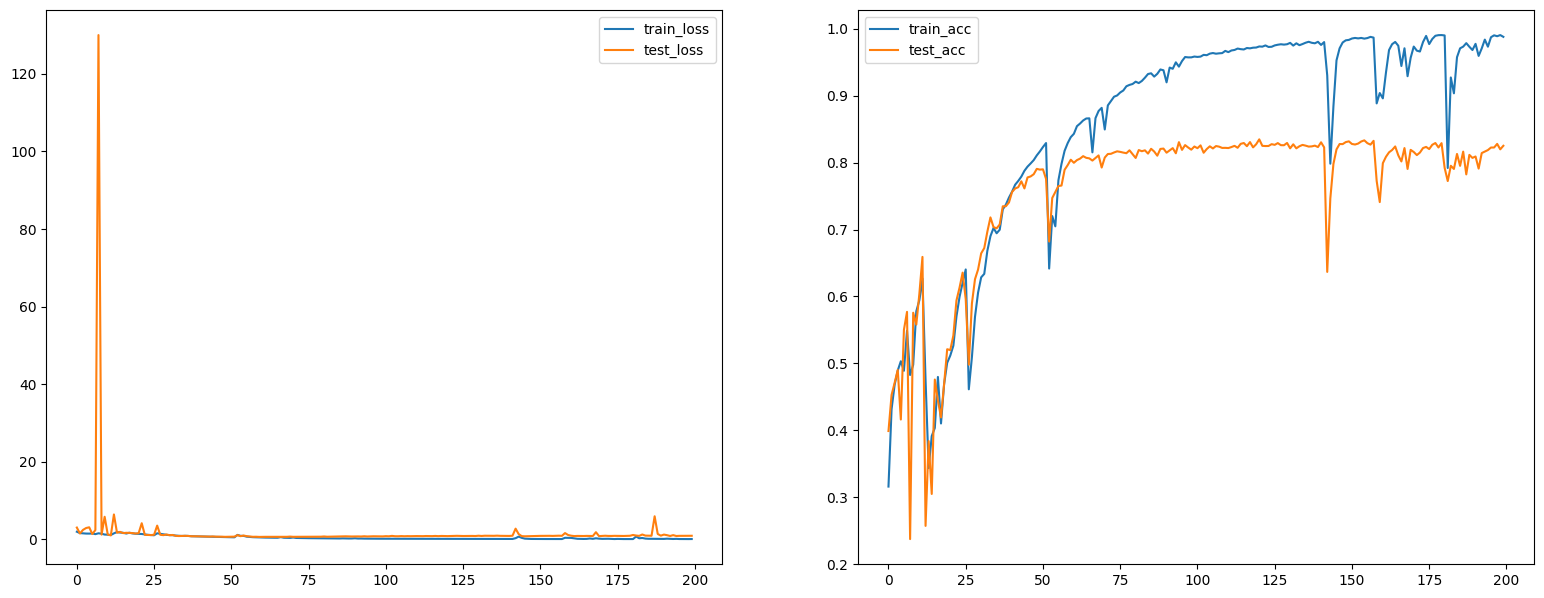

In [ ]:

plt.figure(figsize=(19.2,7.2))
plt.subplot(1, 2, 1)
plt.plot(train_loss_list, label='train_loss')
plt.plot(test_loss_list, label='test_loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_acc_list, label='train_acc')
plt.plot(test_acc_list, label='test_acc')
plt.legend()

plt.show()

In [ ]:
# HINT: Remember to change the model to 'resnet50' and the weights to weights="IMAGENET1K_V1" when needed.
model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet50', weights="IMAGENET1K_V1")

# Background: The original resnet18 is designed for ImageNet dataset to predict 1000 classes.
# TODO: Change the output of the model to 10 class.
model.fc = nn.Linear(model.fc.in_features, out_features=10, bias=True)
model = model.to(device)

Downloading: "https://github.com/pytorch/vision/zipball/v0.10.0" to /root/.cache/torch/hub/v0.10.0.zip
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 177MB/s]


In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)

epochs = 200

In [ ]:
train_loss_list = []
train_acc_list = []
test_loss_list = []
test_acc_list = []
best_acc = 0

for epoch in range(epochs):
    train_loss, train_acc = train(train_dataloader, model, loss_fn, optimizer)
    test_loss, test_acc = test(valid_dataloader, model, loss_fn)
    train_loss_list.append(train_loss)
    train_acc_list.append(train_acc)
    test_loss_list.append(test_loss)
    test_acc_list.append(test_acc)
    if test_acc > best_acc:
      best_acc = test_acc
    print(f"Epoch {epoch + 1:2d}: Loss = {train_loss:.4f} Acc = {train_acc:.2f} Test_Loss = {test_loss:.4f} Test_Acc = {test_acc:.2f}")
    writer.add_scalar('Loss/train', train_loss, epoch)
    writer.add_scalar('Loss/test', test_loss, epoch)
    writer.add_scalar('Acc/train', train_acc, epoch)
    writer.add_scalar('Acc/test', test_acc, epoch)

writer.close()

100%|██████████| 40/40 [00:03<00:00, 11.14it/s]


Epoch  1: Loss = 0.9467 Acc = 0.67 Test_Loss = 1.2191 Test_Acc = 0.73


100%|██████████| 40/40 [00:03<00:00, 10.09it/s]


Epoch  2: Loss = 0.6649 Acc = 0.77 Test_Loss = 0.7660 Test_Acc = 0.75


100%|██████████| 40/40 [00:04<00:00,  8.98it/s]


Epoch  3: Loss = 0.5540 Acc = 0.81 Test_Loss = 0.5821 Test_Acc = 0.81


100%|██████████| 40/40 [00:03<00:00, 11.41it/s]


Epoch  4: Loss = 0.5410 Acc = 0.81 Test_Loss = 1.1525 Test_Acc = 0.69


100%|██████████| 40/40 [00:03<00:00, 11.42it/s]


Epoch  5: Loss = 0.5341 Acc = 0.82 Test_Loss = 0.5960 Test_Acc = 0.80


100%|██████████| 40/40 [00:04<00:00,  9.44it/s]


Epoch  6: Loss = 0.4601 Acc = 0.84 Test_Loss = 0.5203 Test_Acc = 0.82


100%|██████████| 40/40 [00:03<00:00, 10.20it/s]


Epoch  7: Loss = 0.4285 Acc = 0.85 Test_Loss = 0.5579 Test_Acc = 0.83


100%|██████████| 40/40 [00:03<00:00, 11.49it/s]


Epoch  8: Loss = 0.4129 Acc = 0.86 Test_Loss = 0.4463 Test_Acc = 0.85


100%|██████████| 40/40 [00:03<00:00, 11.58it/s]


Epoch  9: Loss = 0.3801 Acc = 0.87 Test_Loss = 0.5141 Test_Acc = 0.83


100%|██████████| 40/40 [00:04<00:00,  8.29it/s]


Epoch 10: Loss = 0.4113 Acc = 0.86 Test_Loss = 1.3621 Test_Acc = 0.61


100%|██████████| 40/40 [00:03<00:00, 11.38it/s]


Epoch 11: Loss = 0.8143 Acc = 0.73 Test_Loss = 1.6211 Test_Acc = 0.59


100%|██████████| 40/40 [00:03<00:00, 11.54it/s]


Epoch 12: Loss = 0.6060 Acc = 0.79 Test_Loss = 0.4999 Test_Acc = 0.83


100%|██████████| 40/40 [00:03<00:00, 10.06it/s]


Epoch 13: Loss = 0.4327 Acc = 0.85 Test_Loss = 0.4505 Test_Acc = 0.84


100%|██████████| 40/40 [00:04<00:00,  9.38it/s]


Epoch 14: Loss = 0.3741 Acc = 0.87 Test_Loss = 0.4435 Test_Acc = 0.85


100%|██████████| 40/40 [00:03<00:00, 11.49it/s]


Epoch 15: Loss = 0.3464 Acc = 0.88 Test_Loss = 0.4272 Test_Acc = 0.86


100%|██████████| 40/40 [00:03<00:00, 11.64it/s]


Epoch 16: Loss = 0.3252 Acc = 0.89 Test_Loss = 0.4624 Test_Acc = 0.85


100%|██████████| 40/40 [00:04<00:00,  8.81it/s]


Epoch 17: Loss = 0.3084 Acc = 0.89 Test_Loss = 0.4188 Test_Acc = 0.86


100%|██████████| 40/40 [00:03<00:00, 11.04it/s]


Epoch 18: Loss = 0.2926 Acc = 0.90 Test_Loss = 0.4157 Test_Acc = 0.86


100%|██████████| 40/40 [00:03<00:00, 11.19it/s]


Epoch 19: Loss = 0.2895 Acc = 0.90 Test_Loss = 0.4343 Test_Acc = 0.86


100%|██████████| 40/40 [00:03<00:00, 10.65it/s]


Epoch 20: Loss = 0.2714 Acc = 0.91 Test_Loss = 0.4598 Test_Acc = 0.85


100%|██████████| 40/40 [00:04<00:00,  8.82it/s]


Epoch 21: Loss = 0.2636 Acc = 0.91 Test_Loss = 0.4391 Test_Acc = 0.86


100%|██████████| 40/40 [00:03<00:00, 11.39it/s]


Epoch 22: Loss = 0.2583 Acc = 0.91 Test_Loss = 0.4241 Test_Acc = 0.86


100%|██████████| 40/40 [00:03<00:00, 11.56it/s]


Epoch 23: Loss = 0.2527 Acc = 0.91 Test_Loss = 0.4223 Test_Acc = 0.87


100%|██████████| 40/40 [00:04<00:00,  9.15it/s]


Epoch 24: Loss = 0.2410 Acc = 0.92 Test_Loss = 0.4352 Test_Acc = 0.86


100%|██████████| 40/40 [00:03<00:00, 10.52it/s]


Epoch 25: Loss = 0.2985 Acc = 0.90 Test_Loss = 0.4267 Test_Acc = 0.87


100%|██████████| 40/40 [00:03<00:00, 11.40it/s]


Epoch 26: Loss = 0.2435 Acc = 0.91 Test_Loss = 0.4007 Test_Acc = 0.87


100%|██████████| 40/40 [00:03<00:00, 11.17it/s]


Epoch 27: Loss = 0.2260 Acc = 0.92 Test_Loss = 0.4298 Test_Acc = 0.87


100%|██████████| 40/40 [00:04<00:00,  8.83it/s]


Epoch 28: Loss = 0.2581 Acc = 0.91 Test_Loss = 0.5216 Test_Acc = 0.84


100%|██████████| 40/40 [00:03<00:00, 11.48it/s]


Epoch 29: Loss = 0.2499 Acc = 0.91 Test_Loss = 0.4559 Test_Acc = 0.86


100%|██████████| 40/40 [00:03<00:00, 11.24it/s]


Epoch 30: Loss = 0.2188 Acc = 0.92 Test_Loss = 0.4224 Test_Acc = 0.87


100%|██████████| 40/40 [00:04<00:00,  9.40it/s]


Epoch 31: Loss = 0.2064 Acc = 0.93 Test_Loss = 0.4182 Test_Acc = 0.87


100%|██████████| 40/40 [00:03<00:00, 10.52it/s]


Epoch 32: Loss = 0.2017 Acc = 0.93 Test_Loss = 0.4492 Test_Acc = 0.86


100%|██████████| 40/40 [00:03<00:00, 11.10it/s]


Epoch 33: Loss = 0.1966 Acc = 0.93 Test_Loss = 0.4154 Test_Acc = 0.87


100%|██████████| 40/40 [00:03<00:00, 11.06it/s]


Epoch 34: Loss = 0.1875 Acc = 0.93 Test_Loss = 0.4274 Test_Acc = 0.87


100%|██████████| 40/40 [00:04<00:00,  8.52it/s]


Epoch 35: Loss = 0.1837 Acc = 0.94 Test_Loss = 0.4288 Test_Acc = 0.87


100%|██████████| 40/40 [00:03<00:00, 11.37it/s]


Epoch 36: Loss = 0.1820 Acc = 0.94 Test_Loss = 0.4366 Test_Acc = 0.87


100%|██████████| 40/40 [00:03<00:00, 11.17it/s]


Epoch 37: Loss = 0.1789 Acc = 0.94 Test_Loss = 0.4563 Test_Acc = 0.87


100%|██████████| 40/40 [00:04<00:00,  9.68it/s]


Epoch 38: Loss = 0.1745 Acc = 0.94 Test_Loss = 0.4356 Test_Acc = 0.87


100%|██████████| 40/40 [00:03<00:00, 10.35it/s]


Epoch 39: Loss = 0.1718 Acc = 0.94 Test_Loss = 0.4485 Test_Acc = 0.87


100%|██████████| 40/40 [00:03<00:00, 11.39it/s]


Epoch 40: Loss = 0.1665 Acc = 0.94 Test_Loss = 0.4508 Test_Acc = 0.87


100%|██████████| 40/40 [00:03<00:00, 11.20it/s]


Epoch 41: Loss = 0.1647 Acc = 0.94 Test_Loss = 0.4401 Test_Acc = 0.88


100%|██████████| 40/40 [00:04<00:00,  8.44it/s]


Epoch 42: Loss = 0.2985 Acc = 0.90 Test_Loss = 0.4422 Test_Acc = 0.87


100%|██████████| 40/40 [00:03<00:00, 11.39it/s]


Epoch 43: Loss = 0.1938 Acc = 0.93 Test_Loss = 0.4514 Test_Acc = 0.87


100%|██████████| 40/40 [00:03<00:00, 11.40it/s]


Epoch 44: Loss = 0.1653 Acc = 0.94 Test_Loss = 0.4187 Test_Acc = 0.88


100%|██████████| 40/40 [00:04<00:00,  9.88it/s]


Epoch 45: Loss = 0.1507 Acc = 0.95 Test_Loss = 0.4489 Test_Acc = 0.88


100%|██████████| 40/40 [00:04<00:00,  9.07it/s]


Epoch 46: Loss = 0.1481 Acc = 0.95 Test_Loss = 0.4424 Test_Acc = 0.88


100%|██████████| 40/40 [00:03<00:00, 11.42it/s]


Epoch 47: Loss = 0.1392 Acc = 0.95 Test_Loss = 0.4639 Test_Acc = 0.87


100%|██████████| 40/40 [00:03<00:00, 11.44it/s]


Epoch 48: Loss = 0.1344 Acc = 0.95 Test_Loss = 0.4563 Test_Acc = 0.87


100%|██████████| 40/40 [00:04<00:00,  8.47it/s]


Epoch 49: Loss = 0.3306 Acc = 0.89 Test_Loss = 0.4500 Test_Acc = 0.86


100%|██████████| 40/40 [00:03<00:00, 11.10it/s]


Epoch 50: Loss = 0.1941 Acc = 0.93 Test_Loss = 0.4322 Test_Acc = 0.87


100%|██████████| 40/40 [00:03<00:00, 11.35it/s]


Epoch 51: Loss = 0.1522 Acc = 0.95 Test_Loss = 0.4599 Test_Acc = 0.87


100%|██████████| 40/40 [00:03<00:00, 11.03it/s]


Epoch 52: Loss = 0.1343 Acc = 0.95 Test_Loss = 0.4612 Test_Acc = 0.87


100%|██████████| 40/40 [00:04<00:00,  8.83it/s]


Epoch 53: Loss = 0.1271 Acc = 0.96 Test_Loss = 0.4408 Test_Acc = 0.87


100%|██████████| 40/40 [00:03<00:00, 11.51it/s]


Epoch 54: Loss = 0.1216 Acc = 0.96 Test_Loss = 0.4729 Test_Acc = 0.87


100%|██████████| 40/40 [00:03<00:00, 11.57it/s]


Epoch 55: Loss = 0.1192 Acc = 0.96 Test_Loss = 0.4864 Test_Acc = 0.87


100%|██████████| 40/40 [00:04<00:00,  9.86it/s]


Epoch 56: Loss = 0.1173 Acc = 0.96 Test_Loss = 0.4956 Test_Acc = 0.87


100%|██████████| 40/40 [00:04<00:00,  9.31it/s]


Epoch 57: Loss = 0.1188 Acc = 0.96 Test_Loss = 0.4845 Test_Acc = 0.87


100%|██████████| 40/40 [00:03<00:00, 11.62it/s]


Epoch 58: Loss = 0.1084 Acc = 0.96 Test_Loss = 0.4713 Test_Acc = 0.88


100%|██████████| 40/40 [00:03<00:00, 11.46it/s]


Epoch 59: Loss = 0.1095 Acc = 0.96 Test_Loss = 0.4539 Test_Acc = 0.88


100%|██████████| 40/40 [00:04<00:00,  8.89it/s]


Epoch 60: Loss = 0.1084 Acc = 0.96 Test_Loss = 0.5020 Test_Acc = 0.87


100%|██████████| 40/40 [00:03<00:00, 11.52it/s]


Epoch 61: Loss = 0.1108 Acc = 0.96 Test_Loss = 0.4806 Test_Acc = 0.87


100%|██████████| 40/40 [00:03<00:00, 11.45it/s]


Epoch 62: Loss = 0.1074 Acc = 0.96 Test_Loss = 0.4798 Test_Acc = 0.88


100%|██████████| 40/40 [00:03<00:00, 10.76it/s]


Epoch 63: Loss = 0.1048 Acc = 0.96 Test_Loss = 0.4887 Test_Acc = 0.88


100%|██████████| 40/40 [00:04<00:00,  8.71it/s]


Epoch 64: Loss = 0.1025 Acc = 0.96 Test_Loss = 0.5835 Test_Acc = 0.86


100%|██████████| 40/40 [00:03<00:00, 11.35it/s]


Epoch 65: Loss = 0.2026 Acc = 0.93 Test_Loss = 0.4980 Test_Acc = 0.87


100%|██████████| 40/40 [00:03<00:00, 10.91it/s]


Epoch 66: Loss = 0.1195 Acc = 0.96 Test_Loss = 0.5077 Test_Acc = 0.87


100%|██████████| 40/40 [00:04<00:00,  8.96it/s]


Epoch 67: Loss = 0.1075 Acc = 0.96 Test_Loss = 0.4745 Test_Acc = 0.88


100%|██████████| 40/40 [00:03<00:00, 10.75it/s]


Epoch 68: Loss = 0.1009 Acc = 0.96 Test_Loss = 0.4731 Test_Acc = 0.88


100%|██████████| 40/40 [00:03<00:00, 11.60it/s]


Epoch 69: Loss = 0.0967 Acc = 0.97 Test_Loss = 0.4927 Test_Acc = 0.88


100%|██████████| 40/40 [00:03<00:00, 11.12it/s]


Epoch 70: Loss = 0.0906 Acc = 0.97 Test_Loss = 0.5088 Test_Acc = 0.88


100%|██████████| 40/40 [00:04<00:00,  8.99it/s]


Epoch 71: Loss = 0.0980 Acc = 0.97 Test_Loss = 0.5250 Test_Acc = 0.88


100%|██████████| 40/40 [00:03<00:00, 11.69it/s]


Epoch 72: Loss = 0.0887 Acc = 0.97 Test_Loss = 0.4955 Test_Acc = 0.88


100%|██████████| 40/40 [00:03<00:00, 11.61it/s]


Epoch 73: Loss = 0.0903 Acc = 0.97 Test_Loss = 0.4703 Test_Acc = 0.88


100%|██████████| 40/40 [00:03<00:00, 10.60it/s]


Epoch 74: Loss = 0.0903 Acc = 0.97 Test_Loss = 0.5566 Test_Acc = 0.87


100%|██████████| 40/40 [00:04<00:00,  9.15it/s]


Epoch 75: Loss = 0.0902 Acc = 0.97 Test_Loss = 0.4815 Test_Acc = 0.88


100%|██████████| 40/40 [00:03<00:00, 11.50it/s]


Epoch 76: Loss = 0.0870 Acc = 0.97 Test_Loss = 0.4988 Test_Acc = 0.88


100%|██████████| 40/40 [00:03<00:00, 11.34it/s]


Epoch 77: Loss = 0.0874 Acc = 0.97 Test_Loss = 0.5616 Test_Acc = 0.87


100%|██████████| 40/40 [00:04<00:00,  8.38it/s]


Epoch 78: Loss = 0.2205 Acc = 0.93 Test_Loss = 0.5006 Test_Acc = 0.87


100%|██████████| 40/40 [00:03<00:00, 11.16it/s]


Epoch 79: Loss = 0.1077 Acc = 0.96 Test_Loss = 0.4900 Test_Acc = 0.88


100%|██████████| 40/40 [00:03<00:00, 11.33it/s]


Epoch 80: Loss = 0.0880 Acc = 0.97 Test_Loss = 0.5056 Test_Acc = 0.88


100%|██████████| 40/40 [00:03<00:00, 10.19it/s]


Epoch 81: Loss = 0.0849 Acc = 0.97 Test_Loss = 0.5140 Test_Acc = 0.88


100%|██████████| 40/40 [00:04<00:00,  9.11it/s]


Epoch 82: Loss = 0.0777 Acc = 0.97 Test_Loss = 0.5135 Test_Acc = 0.88


100%|██████████| 40/40 [00:03<00:00, 11.26it/s]


Epoch 83: Loss = 0.0778 Acc = 0.97 Test_Loss = 0.5344 Test_Acc = 0.87


100%|██████████| 40/40 [00:03<00:00, 11.32it/s]


Epoch 84: Loss = 0.0785 Acc = 0.97 Test_Loss = 0.5563 Test_Acc = 0.87


100%|██████████| 40/40 [00:04<00:00,  8.40it/s]


Epoch 85: Loss = 0.0758 Acc = 0.97 Test_Loss = 0.5439 Test_Acc = 0.88


100%|██████████| 40/40 [00:03<00:00, 11.51it/s]


Epoch 86: Loss = 0.0761 Acc = 0.97 Test_Loss = 0.5074 Test_Acc = 0.89


100%|██████████| 40/40 [00:03<00:00, 11.42it/s]


Epoch 87: Loss = 0.0728 Acc = 0.97 Test_Loss = 0.5413 Test_Acc = 0.88


100%|██████████| 40/40 [00:03<00:00, 10.28it/s]


Epoch 88: Loss = 0.0811 Acc = 0.97 Test_Loss = 0.5104 Test_Acc = 0.88


100%|██████████| 40/40 [00:04<00:00,  9.12it/s]


Epoch 89: Loss = 0.0730 Acc = 0.97 Test_Loss = 0.5339 Test_Acc = 0.88


100%|██████████| 40/40 [00:03<00:00, 10.74it/s]


Epoch 90: Loss = 0.0783 Acc = 0.97 Test_Loss = 0.5361 Test_Acc = 0.88


100%|██████████| 40/40 [00:03<00:00, 11.05it/s]


Epoch 91: Loss = 0.0738 Acc = 0.97 Test_Loss = 0.5487 Test_Acc = 0.87


100%|██████████| 40/40 [00:04<00:00,  8.57it/s]


Epoch 92: Loss = 0.0732 Acc = 0.97 Test_Loss = 0.5544 Test_Acc = 0.87


100%|██████████| 40/40 [00:03<00:00, 11.35it/s]


Epoch 93: Loss = 0.0708 Acc = 0.98 Test_Loss = 0.5620 Test_Acc = 0.87


100%|██████████| 40/40 [00:03<00:00, 11.28it/s]


Epoch 94: Loss = 0.0727 Acc = 0.97 Test_Loss = 0.5429 Test_Acc = 0.88


100%|██████████| 40/40 [00:03<00:00, 10.25it/s]


Epoch 95: Loss = 0.0707 Acc = 0.98 Test_Loss = 0.5463 Test_Acc = 0.88


100%|██████████| 40/40 [00:04<00:00,  9.06it/s]


Epoch 96: Loss = 0.0761 Acc = 0.97 Test_Loss = 0.5446 Test_Acc = 0.88


100%|██████████| 40/40 [00:03<00:00, 11.53it/s]


Epoch 97: Loss = 0.0699 Acc = 0.98 Test_Loss = 0.5461 Test_Acc = 0.88


100%|██████████| 40/40 [00:03<00:00, 11.34it/s]


Epoch 98: Loss = 0.0726 Acc = 0.98 Test_Loss = 0.5331 Test_Acc = 0.88


100%|██████████| 40/40 [00:04<00:00,  8.33it/s]


Epoch 99: Loss = 0.0750 Acc = 0.97 Test_Loss = 0.5175 Test_Acc = 0.88


100%|██████████| 40/40 [00:03<00:00, 11.36it/s]


Epoch 100: Loss = 0.0699 Acc = 0.98 Test_Loss = 0.5427 Test_Acc = 0.88


100%|██████████| 40/40 [00:03<00:00, 11.29it/s]


Epoch 101: Loss = 0.0724 Acc = 0.97 Test_Loss = 0.5195 Test_Acc = 0.88


100%|██████████| 40/40 [00:04<00:00,  9.94it/s]


Epoch 102: Loss = 0.0685 Acc = 0.98 Test_Loss = 0.5232 Test_Acc = 0.88


100%|██████████| 40/40 [00:04<00:00,  9.68it/s]


Epoch 103: Loss = 0.0685 Acc = 0.98 Test_Loss = 0.5239 Test_Acc = 0.88


100%|██████████| 40/40 [00:03<00:00, 11.67it/s]


Epoch 104: Loss = 0.0651 Acc = 0.98 Test_Loss = 0.5542 Test_Acc = 0.87


100%|██████████| 40/40 [00:03<00:00, 11.41it/s]


Epoch 105: Loss = 0.0674 Acc = 0.98 Test_Loss = 0.5321 Test_Acc = 0.88


100%|██████████| 40/40 [00:04<00:00,  8.46it/s]


Epoch 106: Loss = 0.0666 Acc = 0.98 Test_Loss = 0.5648 Test_Acc = 0.87


100%|██████████| 40/40 [00:03<00:00, 11.11it/s]


Epoch 107: Loss = 0.0651 Acc = 0.98 Test_Loss = 0.5475 Test_Acc = 0.88


100%|██████████| 40/40 [00:03<00:00, 11.41it/s]


Epoch 108: Loss = 0.0677 Acc = 0.98 Test_Loss = 0.5537 Test_Acc = 0.88


100%|██████████| 40/40 [00:04<00:00,  9.47it/s]


Epoch 109: Loss = 0.0596 Acc = 0.98 Test_Loss = 0.5671 Test_Acc = 0.88


100%|██████████| 40/40 [00:04<00:00,  9.46it/s]


Epoch 110: Loss = 0.0637 Acc = 0.98 Test_Loss = 0.5468 Test_Acc = 0.88


100%|██████████| 40/40 [00:03<00:00, 11.21it/s]


Epoch 111: Loss = 0.0641 Acc = 0.98 Test_Loss = 0.5656 Test_Acc = 0.87


100%|██████████| 40/40 [00:03<00:00, 11.38it/s]


Epoch 112: Loss = 0.0636 Acc = 0.98 Test_Loss = 0.5459 Test_Acc = 0.88


100%|██████████| 40/40 [00:04<00:00,  8.36it/s]


Epoch 113: Loss = 0.0606 Acc = 0.98 Test_Loss = 0.5436 Test_Acc = 0.88


100%|██████████| 40/40 [00:03<00:00, 11.43it/s]


Epoch 114: Loss = 0.0586 Acc = 0.98 Test_Loss = 0.5571 Test_Acc = 0.88


100%|██████████| 40/40 [00:03<00:00, 11.18it/s]


Epoch 115: Loss = 0.0597 Acc = 0.98 Test_Loss = 0.5606 Test_Acc = 0.88


100%|██████████| 40/40 [00:04<00:00,  9.49it/s]


Epoch 116: Loss = 0.0607 Acc = 0.98 Test_Loss = 0.5765 Test_Acc = 0.88


100%|██████████| 40/40 [00:03<00:00, 10.36it/s]


Epoch 117: Loss = 0.0610 Acc = 0.98 Test_Loss = 0.5745 Test_Acc = 0.87


100%|██████████| 40/40 [00:03<00:00, 11.62it/s]


Epoch 118: Loss = 0.0568 Acc = 0.98 Test_Loss = 0.5531 Test_Acc = 0.88


100%|██████████| 40/40 [00:03<00:00, 10.96it/s]


Epoch 119: Loss = 0.0601 Acc = 0.98 Test_Loss = 0.5582 Test_Acc = 0.88


100%|██████████| 40/40 [00:04<00:00,  8.30it/s]


Epoch 120: Loss = 0.0573 Acc = 0.98 Test_Loss = 0.5418 Test_Acc = 0.88


100%|██████████| 40/40 [00:03<00:00, 11.56it/s]


Epoch 121: Loss = 0.2492 Acc = 0.92 Test_Loss = 0.4801 Test_Acc = 0.88


100%|██████████| 40/40 [00:03<00:00, 11.47it/s]


Epoch 122: Loss = 0.0974 Acc = 0.97 Test_Loss = 0.5010 Test_Acc = 0.88


100%|██████████| 40/40 [00:04<00:00,  9.76it/s]


Epoch 123: Loss = 0.0684 Acc = 0.98 Test_Loss = 0.5281 Test_Acc = 0.88


100%|██████████| 40/40 [00:03<00:00, 10.15it/s]


Epoch 124: Loss = 0.0614 Acc = 0.98 Test_Loss = 0.5288 Test_Acc = 0.88


100%|██████████| 40/40 [00:03<00:00, 11.40it/s]


Epoch 125: Loss = 0.0552 Acc = 0.98 Test_Loss = 0.5274 Test_Acc = 0.88


100%|██████████| 40/40 [00:03<00:00, 11.47it/s]


Epoch 126: Loss = 0.0516 Acc = 0.98 Test_Loss = 0.5344 Test_Acc = 0.88


100%|██████████| 40/40 [00:04<00:00,  8.49it/s]


Epoch 127: Loss = 0.0536 Acc = 0.98 Test_Loss = 0.5659 Test_Acc = 0.88


100%|██████████| 40/40 [00:03<00:00, 11.34it/s]


Epoch 128: Loss = 0.0511 Acc = 0.98 Test_Loss = 0.5666 Test_Acc = 0.88


100%|██████████| 40/40 [00:03<00:00, 11.36it/s]


Epoch 129: Loss = 0.0464 Acc = 0.98 Test_Loss = 0.5755 Test_Acc = 0.88


100%|██████████| 40/40 [00:04<00:00,  9.11it/s]


Epoch 130: Loss = 0.0510 Acc = 0.98 Test_Loss = 0.5388 Test_Acc = 0.88


100%|██████████| 40/40 [00:03<00:00, 10.04it/s]


Epoch 131: Loss = 0.0459 Acc = 0.98 Test_Loss = 0.5794 Test_Acc = 0.88


100%|██████████| 40/40 [00:03<00:00, 11.42it/s]


Epoch 132: Loss = 0.0519 Acc = 0.98 Test_Loss = 0.5841 Test_Acc = 0.88


100%|██████████| 40/40 [00:03<00:00, 10.80it/s]


Epoch 133: Loss = 0.0475 Acc = 0.98 Test_Loss = 0.5610 Test_Acc = 0.88


100%|██████████| 40/40 [00:04<00:00,  8.59it/s]


Epoch 134: Loss = 0.0534 Acc = 0.98 Test_Loss = 0.6083 Test_Acc = 0.88


100%|██████████| 40/40 [00:03<00:00, 11.47it/s]


Epoch 135: Loss = 0.0473 Acc = 0.98 Test_Loss = 0.5631 Test_Acc = 0.88


100%|██████████| 40/40 [00:03<00:00, 11.03it/s]


Epoch 136: Loss = 0.0491 Acc = 0.98 Test_Loss = 0.6259 Test_Acc = 0.87


100%|██████████| 40/40 [00:04<00:00,  8.64it/s]


Epoch 137: Loss = 0.0539 Acc = 0.98 Test_Loss = 0.5452 Test_Acc = 0.88


100%|██████████| 40/40 [00:03<00:00, 11.08it/s]


Epoch 138: Loss = 0.0502 Acc = 0.98 Test_Loss = 0.5542 Test_Acc = 0.89


100%|██████████| 40/40 [00:03<00:00, 11.26it/s]


Epoch 139: Loss = 0.0487 Acc = 0.98 Test_Loss = 0.5432 Test_Acc = 0.88


100%|██████████| 40/40 [00:03<00:00, 10.43it/s]


Epoch 140: Loss = 0.0507 Acc = 0.98 Test_Loss = 0.5836 Test_Acc = 0.88


100%|██████████| 40/40 [00:04<00:00,  9.07it/s]


Epoch 141: Loss = 0.0530 Acc = 0.98 Test_Loss = 0.5756 Test_Acc = 0.88


100%|██████████| 40/40 [00:03<00:00, 11.10it/s]


Epoch 142: Loss = 0.0491 Acc = 0.98 Test_Loss = 0.5723 Test_Acc = 0.88


100%|██████████| 40/40 [00:03<00:00, 11.39it/s]


Epoch 143: Loss = 0.0498 Acc = 0.98 Test_Loss = 0.5574 Test_Acc = 0.88


100%|██████████| 40/40 [00:04<00:00,  8.25it/s]


Epoch 144: Loss = 0.0513 Acc = 0.98 Test_Loss = 0.5492 Test_Acc = 0.88


100%|██████████| 40/40 [00:03<00:00, 10.89it/s]


Epoch 145: Loss = 0.0504 Acc = 0.98 Test_Loss = 0.5472 Test_Acc = 0.88


100%|██████████| 40/40 [00:03<00:00, 11.25it/s]


Epoch 146: Loss = 0.0484 Acc = 0.98 Test_Loss = 0.5644 Test_Acc = 0.88


100%|██████████| 40/40 [00:04<00:00,  9.61it/s]


Epoch 147: Loss = 0.0492 Acc = 0.98 Test_Loss = 0.5701 Test_Acc = 0.88


100%|██████████| 40/40 [00:04<00:00,  9.73it/s]


Epoch 148: Loss = 0.0532 Acc = 0.98 Test_Loss = 0.5871 Test_Acc = 0.88


100%|██████████| 40/40 [00:03<00:00, 11.15it/s]


Epoch 149: Loss = 0.0511 Acc = 0.98 Test_Loss = 0.5634 Test_Acc = 0.88


100%|██████████| 40/40 [00:03<00:00, 10.88it/s]


Epoch 150: Loss = 0.0480 Acc = 0.98 Test_Loss = 0.5738 Test_Acc = 0.88


100%|██████████| 40/40 [00:04<00:00,  8.41it/s]


Epoch 151: Loss = 0.0481 Acc = 0.98 Test_Loss = 0.5875 Test_Acc = 0.88


100%|██████████| 40/40 [00:03<00:00, 11.41it/s]


Epoch 152: Loss = 0.0505 Acc = 0.98 Test_Loss = 0.5823 Test_Acc = 0.88


100%|██████████| 40/40 [00:03<00:00, 11.34it/s]


Epoch 153: Loss = 0.0471 Acc = 0.98 Test_Loss = 0.5683 Test_Acc = 0.88


100%|██████████| 40/40 [00:04<00:00,  8.89it/s]


Epoch 154: Loss = 0.0498 Acc = 0.98 Test_Loss = 0.5329 Test_Acc = 0.88


100%|██████████| 40/40 [00:03<00:00, 10.76it/s]


Epoch 155: Loss = 0.0491 Acc = 0.98 Test_Loss = 0.5385 Test_Acc = 0.88


100%|██████████| 40/40 [00:03<00:00, 11.24it/s]


Epoch 156: Loss = 0.0446 Acc = 0.98 Test_Loss = 0.5609 Test_Acc = 0.89


100%|██████████| 40/40 [00:03<00:00, 10.23it/s]


Epoch 157: Loss = 0.0507 Acc = 0.98 Test_Loss = 0.5631 Test_Acc = 0.88


100%|██████████| 40/40 [00:04<00:00,  9.05it/s]


Epoch 158: Loss = 0.0475 Acc = 0.98 Test_Loss = 0.5642 Test_Acc = 0.88


100%|██████████| 40/40 [00:03<00:00, 11.46it/s]


Epoch 159: Loss = 0.0473 Acc = 0.98 Test_Loss = 0.5680 Test_Acc = 0.88


100%|██████████| 40/40 [00:03<00:00, 11.50it/s]


Epoch 160: Loss = 0.0470 Acc = 0.98 Test_Loss = 0.5538 Test_Acc = 0.88


100%|██████████| 40/40 [00:04<00:00,  9.45it/s]


Epoch 161: Loss = 0.0493 Acc = 0.98 Test_Loss = 0.5547 Test_Acc = 0.88


100%|██████████| 40/40 [00:03<00:00, 10.70it/s]


Epoch 162: Loss = 0.0461 Acc = 0.98 Test_Loss = 0.5945 Test_Acc = 0.87


100%|██████████| 40/40 [00:03<00:00, 11.62it/s]


Epoch 163: Loss = 0.3052 Acc = 0.91 Test_Loss = 4.7182 Test_Acc = 0.63


100%|██████████| 40/40 [00:03<00:00, 11.49it/s]


Epoch 164: Loss = 0.4214 Acc = 0.85 Test_Loss = 0.4959 Test_Acc = 0.85


100%|██████████| 40/40 [00:04<00:00,  8.82it/s]


Epoch 165: Loss = 0.1651 Acc = 0.94 Test_Loss = 0.5218 Test_Acc = 0.87


100%|██████████| 40/40 [00:03<00:00, 11.38it/s]


Epoch 166: Loss = 0.0989 Acc = 0.97 Test_Loss = 0.5199 Test_Acc = 0.87


100%|██████████| 40/40 [00:03<00:00, 11.38it/s]


Epoch 167: Loss = 0.0725 Acc = 0.97 Test_Loss = 0.5436 Test_Acc = 0.87


100%|██████████| 40/40 [00:04<00:00,  9.89it/s]


Epoch 168: Loss = 0.0745 Acc = 0.97 Test_Loss = 0.5321 Test_Acc = 0.88


100%|██████████| 40/40 [00:04<00:00,  9.40it/s]


Epoch 169: Loss = 0.0504 Acc = 0.98 Test_Loss = 0.5437 Test_Acc = 0.88


100%|██████████| 40/40 [00:03<00:00, 11.30it/s]


Epoch 170: Loss = 0.0450 Acc = 0.98 Test_Loss = 0.5637 Test_Acc = 0.88


100%|██████████| 40/40 [00:03<00:00, 10.93it/s]


Epoch 171: Loss = 0.0421 Acc = 0.99 Test_Loss = 0.5617 Test_Acc = 0.88


100%|██████████| 40/40 [00:04<00:00,  8.43it/s]


Epoch 172: Loss = 0.0376 Acc = 0.99 Test_Loss = 0.5766 Test_Acc = 0.88


100%|██████████| 40/40 [00:03<00:00, 11.51it/s]


Epoch 173: Loss = 0.0362 Acc = 0.99 Test_Loss = 0.5831 Test_Acc = 0.88


100%|██████████| 40/40 [00:03<00:00, 11.31it/s]


Epoch 174: Loss = 0.0361 Acc = 0.99 Test_Loss = 0.5708 Test_Acc = 0.88


100%|██████████| 40/40 [00:04<00:00,  9.40it/s]


Epoch 175: Loss = 0.0352 Acc = 0.99 Test_Loss = 0.5547 Test_Acc = 0.88


100%|██████████| 40/40 [00:03<00:00, 10.06it/s]


Epoch 176: Loss = 0.0377 Acc = 0.99 Test_Loss = 0.5712 Test_Acc = 0.88


100%|██████████| 40/40 [00:03<00:00, 11.25it/s]


Epoch 177: Loss = 0.0366 Acc = 0.99 Test_Loss = 0.5665 Test_Acc = 0.89


100%|██████████| 40/40 [00:03<00:00, 10.91it/s]


Epoch 178: Loss = 0.0342 Acc = 0.99 Test_Loss = 0.5719 Test_Acc = 0.88


100%|██████████| 40/40 [00:04<00:00,  8.57it/s]


Epoch 179: Loss = 0.0407 Acc = 0.99 Test_Loss = 0.5540 Test_Acc = 0.89


100%|██████████| 40/40 [00:03<00:00, 11.50it/s]


Epoch 180: Loss = 0.0385 Acc = 0.99 Test_Loss = 0.5797 Test_Acc = 0.88


100%|██████████| 40/40 [00:03<00:00, 11.53it/s]


Epoch 181: Loss = 0.0374 Acc = 0.99 Test_Loss = 0.5549 Test_Acc = 0.88


100%|██████████| 40/40 [00:04<00:00,  9.92it/s]


Epoch 182: Loss = 0.0386 Acc = 0.99 Test_Loss = 0.5757 Test_Acc = 0.88


100%|██████████| 40/40 [00:04<00:00,  9.88it/s]


Epoch 183: Loss = 0.0376 Acc = 0.99 Test_Loss = 0.5590 Test_Acc = 0.89


100%|██████████| 40/40 [00:03<00:00, 11.30it/s]


Epoch 184: Loss = 0.0424 Acc = 0.98 Test_Loss = 0.6230 Test_Acc = 0.88


100%|██████████| 40/40 [00:03<00:00, 11.10it/s]


Epoch 185: Loss = 0.0402 Acc = 0.99 Test_Loss = 0.5592 Test_Acc = 0.88


100%|██████████| 40/40 [00:04<00:00,  8.34it/s]


Epoch 186: Loss = 0.0382 Acc = 0.99 Test_Loss = 0.5969 Test_Acc = 0.88


100%|██████████| 40/40 [00:03<00:00, 11.60it/s]


Epoch 187: Loss = 0.0433 Acc = 0.99 Test_Loss = 0.5710 Test_Acc = 0.88


100%|██████████| 40/40 [00:03<00:00, 11.34it/s]


Epoch 188: Loss = 0.0429 Acc = 0.99 Test_Loss = 0.6229 Test_Acc = 0.88


100%|██████████| 40/40 [00:03<00:00, 10.69it/s]


Epoch 189: Loss = 0.5562 Acc = 0.83 Test_Loss = 67.9444 Test_Acc = 0.76


100%|██████████| 40/40 [00:04<00:00,  8.97it/s]


Epoch 190: Loss = 0.2867 Acc = 0.90 Test_Loss = 0.5423 Test_Acc = 0.86


100%|██████████| 40/40 [00:03<00:00, 11.36it/s]


Epoch 191: Loss = 0.1234 Acc = 0.96 Test_Loss = 0.6339 Test_Acc = 0.87


100%|██████████| 40/40 [00:03<00:00, 11.22it/s]


Epoch 192: Loss = 0.0815 Acc = 0.97 Test_Loss = 8.2304 Test_Acc = 0.87


100%|██████████| 40/40 [00:04<00:00,  9.47it/s]


Epoch 193: Loss = 0.0740 Acc = 0.97 Test_Loss = 0.7694 Test_Acc = 0.88


100%|██████████| 40/40 [00:03<00:00, 10.79it/s]


Epoch 194: Loss = 0.0511 Acc = 0.98 Test_Loss = 1.5827 Test_Acc = 0.88


100%|██████████| 40/40 [00:03<00:00, 11.26it/s]


Epoch 195: Loss = 0.0460 Acc = 0.98 Test_Loss = 1.1573 Test_Acc = 0.88


100%|██████████| 40/40 [00:03<00:00, 10.89it/s]


Epoch 196: Loss = 0.0381 Acc = 0.99 Test_Loss = 8.7651 Test_Acc = 0.88


100%|██████████| 40/40 [00:04<00:00,  8.75it/s]


Epoch 197: Loss = 0.0368 Acc = 0.99 Test_Loss = 3.2710 Test_Acc = 0.88


100%|██████████| 40/40 [00:03<00:00, 11.33it/s]


Epoch 198: Loss = 0.0371 Acc = 0.99 Test_Loss = 7.3960 Test_Acc = 0.88


100%|██████████| 40/40 [00:03<00:00, 11.14it/s]


Epoch 199: Loss = 0.0354 Acc = 0.99 Test_Loss = 10.5207 Test_Acc = 0.88


100%|██████████| 40/40 [00:04<00:00,  8.51it/s]

Epoch 200: Loss = 0.0332 Acc = 0.99 Test_Loss = 0.9526 Test_Acc = 0.88


In [ ]:
print(best_acc)

0.8898


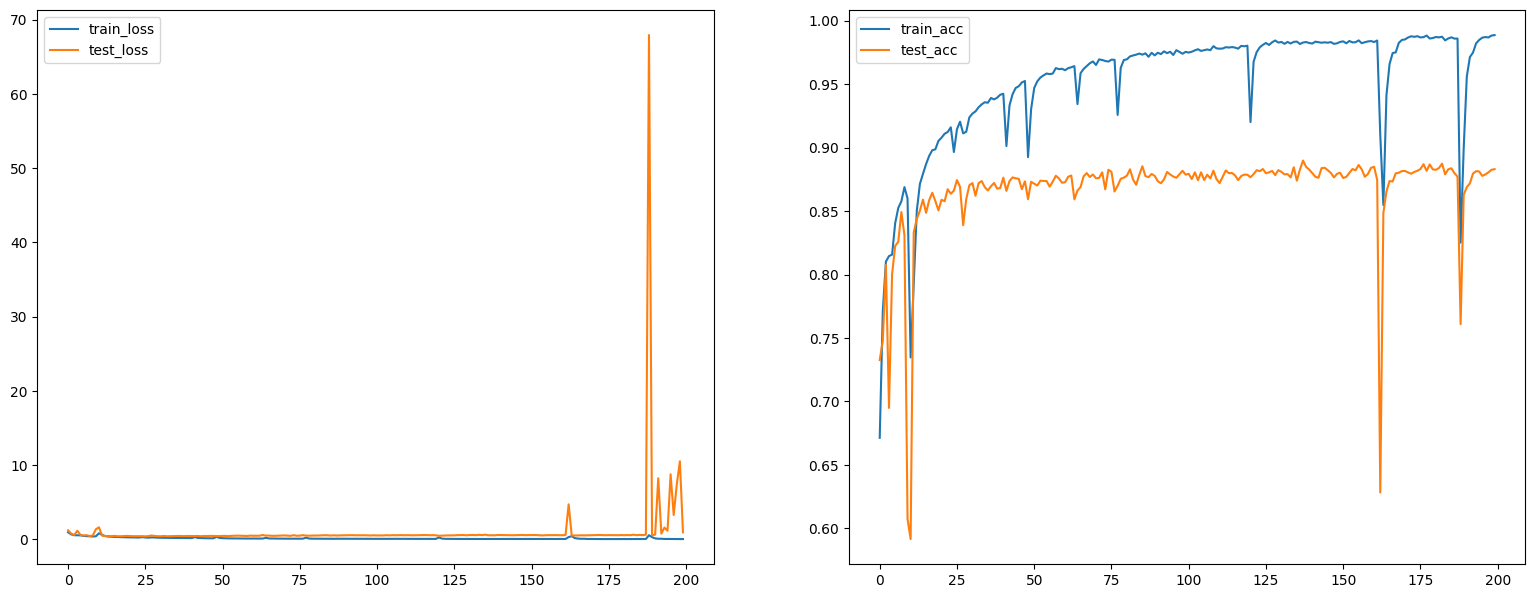

In [ ]:
plt.figure(figsize=(19.2,7.2))
plt.subplot(1, 2, 1)
plt.plot(train_loss_list, label='train_loss')
plt.plot(test_loss_list, label='test_loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_acc_list, label='train_acc')
plt.plot(test_acc_list, label='test_acc')
plt.legend()

plt.show()

## Credits

1. [CIFAR10](https://www.cs.toronto.edu/~kriz/cifar.html)